# Short Term Water Demand Forecasting with Statistical and AI Methods

### Oscar Wooding
Department of Civil and Environmental Engineering, Imperial College London

### Introduction

Analysis of different AI techniques for short term water demand forecasting for the 

In [4]:
# imports 
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
import matplotlib_inline
from datetime import datetime
import warnings
from scipy import stats
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from math import sqrt

%matplotlib inline

# imports for time series analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

# improve matlab output
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

rc('text', usetex=False)
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=11)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# adjust the format of the data set
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

warnings.filterwarnings("ignore")


### Load Data

In [7]:
# load inflow data
inflow_data = pd.read_csv("../data/preprocessed/preprocessed.csv")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('Date')

# change index format to datetime
inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")

# # print first two rows
inflow_data.head(3)

KeyError: "None of ['date_time'] are in the columns"

In [ ]:
# load weather data
weather_data = pd.read_csv("../data/WeatherData.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('date_time')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index, format="%d/%m/%Y %H:%M")

# # print first two rows
weather_data.head(3)

,rain_depth,air_temp,air_humid,windspeed
date_time,,,,
2021-01-01 00:00:00,0.00,7.20,79.00,9.00
2021-01-01 01:00:00,0.00,7.30,79.00,6.00
2021-01-01 02:00:00,0.00,7.60,78.00,4.00


In [ ]:
# clean data

# remove dupes
inflow_data = inflow_data[~inflow_data.index.duplicated(keep='first')]
weather_data = weather_data[~weather_data.index.duplicated(keep='first')]

# set frequency
inflow_data = inflow_data.asfreq(pd.offsets.Hour(), method='pad')
weather_data = weather_data.asfreq(pd.offsets.Hour(), method='pad')

# fill missing using ...
inflow_data_imputed = inflow_data.interpolate(limit=8, method='linear', limit_direction='both') #.bfill()
weather_data_imputed = weather_data.interpolate(limit=8, method='linear', limit_direction='both') #.bfill()

temp_mode = 0 # What default value to take?No
inflow_data_imputed['dma_a'] = inflow_data_imputed['dma_a'].fillna(temp_mode)
inflow_data_imputed['dma_a'].isnull().sum()

# splitting data
pc_train = 0.95 # proportion of data for training
pc_test = 0.05 # proportion of data for testing

nt_train = int(len(inflow_data_imputed)*0.8)

# train data
data_train = {
    'd': inflow_data_imputed[:nt_train],
    'w': weather_data_imputed[:nt_train],
}

# test data
data_test = {
    'd': inflow_data_imputed[nt_train:],
    'w': weather_data_imputed[nt_train:],
}

print('Training data shape: ', data_train['d'].shape)
print('Test data shape: ', data_test['d'].shape)

# normalisation 
# prepare data for normalization
values_train = data_train['d']['dma_c'].values
values_train = values_train.reshape((len(values_train), 1))

# prepare data for normalization
values_test = data_test['d']['dma_c'].values
values_test = values_test.reshape((len(values_test), 1))

# train the normalization on train data
scaler_norm = MinMaxScaler(feature_range=(0, 1))
data_train['d_n'] = data_train['d'][['dma_c']].copy()
data_train['d_n']['dma_c'] = scaler_norm.fit_transform(values_train)

# train the normalization on test data
data_test['d_n'] = data_test['d'][['dma_c']].copy()
data_test['d_n']['dma_c'] = scaler_norm.transform(values_test)

# standardisation
# prepare data for standardization
values = inflow_data_imputed['dma_a'].values
values = values.reshape((len(values), 1))
 
# train the standardization
scaler_std = StandardScaler()
scaler_std = scaler_std.fit(values)
print('Mean: %f, StandardDeviation: %f' % (scaler_std.mean_, sqrt(scaler_std.var_)))


Training data shape:  (10944, 10)
Test data shape:  (2736, 10)
Mean: 8.208821, StandardDeviation: 3.087574


In [ ]:
values

array([[ 0.  ],
       [ 0.  ],
       [ 0.  ],
       ...,
       [11.56],
       [10.42],
       [11.53]])

In [ ]:
# normalize the data set and print the first 5 rows
normalized = scaler_norm.transform(values)
print('Normalised Values \n')
for i in range(5):
    print(normalized[-i])
 
# standardization the data set and print the first 5 rows
print('\nStandardised Values')
standardized = scaler_std.transform(values)
for i in range(5):
    print(standardized[-i])
    
# inverse transform and print the first 5 rows
inversed = scaler_norm.inverse_transform(normalized)
print('\nIntitial Values')
for i in range(5):
    print(inversed[-i])
    

Normalised Values 

[-0.2]
[0.98]
[0.87]
[0.99]
[1.12]

Standardised Values
[-2.66]
[1.08]
[0.72]
[1.09]
[1.5]

Intitial Values
[0.]
[11.53]
[10.42]
[11.56]
[12.84]


In [ ]:
# understanding data
print('Missing Values\n')
print(weather_data_imputed.isna().sum())
print(inflow_data_imputed.isna().sum())

print('\nValue Counts\n')
print(len(weather_data_imputed))
print(len(inflow_data_imputed))

print('\nStatistical Descriptors\n')
print(weather_data_imputed.describe(),'\n')
print(inflow_data_imputed.describe())

Missing Values

rain_depth    0
air_temp      0
air_humid     0
windspeed     0
dtype: int64
dma_a       0
dma_b     258
dma_c      15
dma_d     317
dma_e     292
dma_f    1408
dma_g     938
dma_h     724
dma_i    1221
dma_j     425
dtype: int64

Value Counts

13848
13680

Statistical Descriptors

       rain_depth  air_temp  air_humid  windspeed
count   13,848.00 13,848.00  13,848.00  13,848.00
mean         0.06     15.53      63.63      13.90
std          0.54      7.51      15.46      12.31
min          0.00     -2.10      17.00       1.00
25%          0.00      9.00      53.00       5.00
50%          0.00     14.20      63.00       9.00
75%          0.00     22.50      74.00      18.00
max         28.10     34.60     100.00      77.00 

          dma_a     dma_b     dma_c     dma_d     dma_e     dma_f     dma_g  \
count 13,680.00 13,422.00 13,665.00 13,363.00 13,388.00 12,272.00 12,742.00   
mean       8.21      9.57      4.50     33.60     77.56      8.03     24.24   
std        3

## Analysis

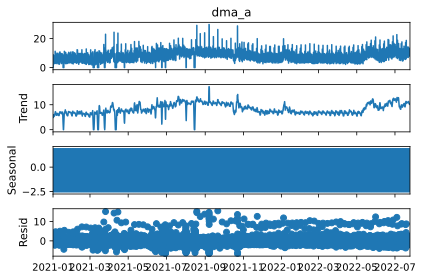

In [ ]:
# Decompose time series (for dma_a)
decomposition = sm.tsa.seasonal_decompose(inflow_data_imputed['dma_a'], model='additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = decomposition.plot()
plt.rcParams['figure.figsize'] = [10.0, 6.0]

In [ ]:
load = inflow_data_imputed['2021-01':'2021-03']

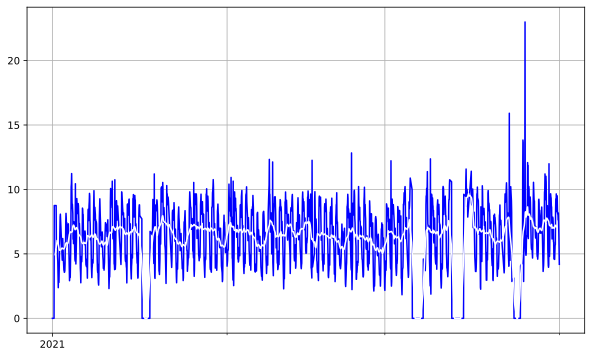

In [ ]:
decomposition = sm.tsa.seasonal_decompose(load['dma_a'], model = 'additive')
 
fig, ax = plt.subplots()
ax.grid(True)
 
year = mdates.YearLocator(month=1)
month = mdates.MonthLocator(interval=1)
 
year_format = mdates.DateFormatter('%Y')
month_format = mdates.DateFormatter('%m')
 
ax.xaxis.set_minor_locator(month)
ax.xaxis.grid(True, which = 'minor')
ax.xaxis.set_major_locator(year)
ax.xaxis.set_major_formatter(year_format)
 
plt.plot(load['dma_a'], c='blue')
plt.plot(decomposition.trend, c='white')

In [ ]:
# creating features
# date time features
inflow_data_imputed['hour'] = [inflow_data_imputed.index[i].hour for i in range(len(inflow_data_imputed))]
inflow_data_imputed['month'] = [inflow_data_imputed.index[i].month for i in range(len(inflow_data_imputed))]
inflow_data_imputed['dayofweek'] = [inflow_data_imputed.index[i].day for i in range(len(inflow_data_imputed))]

inflow_data_imputed['weekend'] = [
    0 if inflow_data_imputed.index[i].day in range(5) 
    else 1 for i in range(len(inflow_data_imputed))
]

# offsets
# offset based on day type (realigns index)
inflow_shift = inflow_data_imputed.shift(4, freq='B')

# generating multiple lags
generated_lagged_features(inflow_data_imputed, 'dma_c', 5)
generated_lagged_features(inflow_data_imputed, 'dma_d', 5)

# rolling window stats
# mix,max,mean
demand = inflow_data_imputed[['dma_c']]
width = 4
shifted = demand.shift(1)

window = shifted.rolling(window=width)
demand_df = pd.concat([window.min(), window.mean(), window.max(), demand], axis=1)
demand_df.columns = ['min', 'mean', 'max', 'demand']

# can also use .expanding for expanding windows
print(demand_df.head(10))


NameError: name 'generated_lagged_features' is not defined

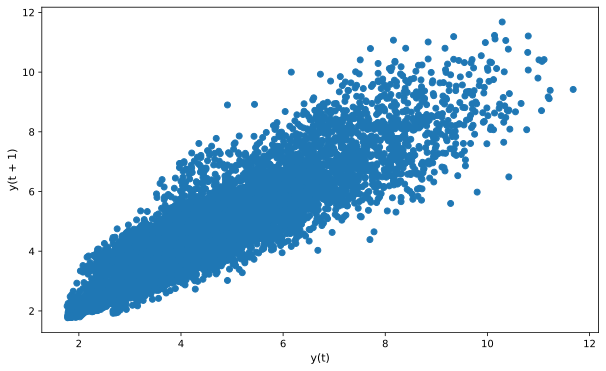

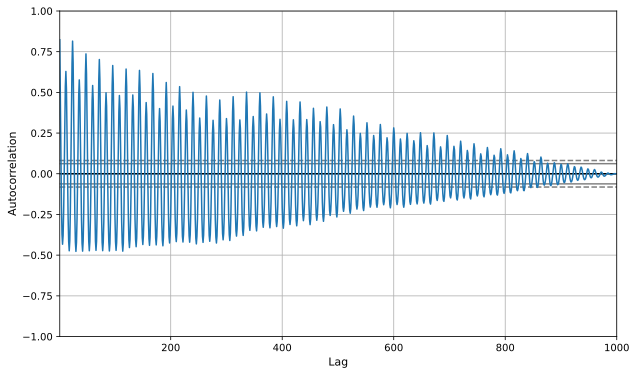

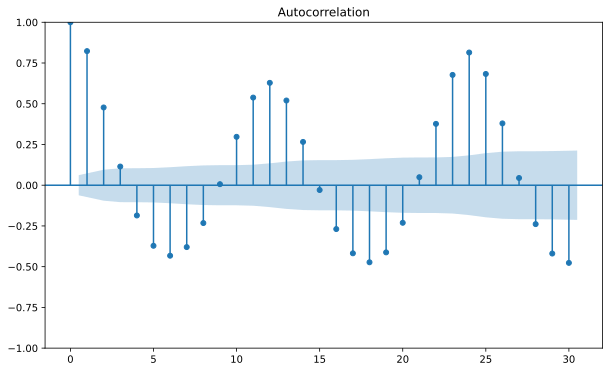

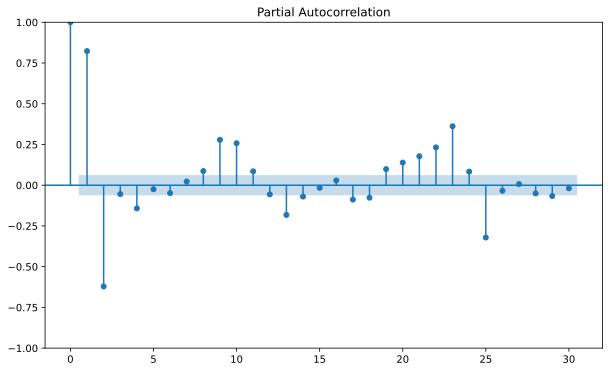

In [ ]:
# analysing randomness
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure()
 
# Pass the lag argument and plot the values. 
# When lag=1 the plot is essentially data[:-1] vs. data[1:]
# Plot our ts_data_load set
lag_plot(inflow_data_imputed['dma_c'])

# Lag plots are used to check if a data set or time series 
# is random: random data should not exhibit any structure 
# in the lag plot.

# Import autocorrelation_plot function
from pandas.plotting import autocorrelation_plot
plt.figure()
 
# Pass the autocorrelation argument and plot the values
autocorrelation_plot(inflow_data_imputed[-1000:]['dma_c'])
 
# Plot the acf function on the ts_data_load set
plot_acf(inflow_data_imputed[-1000:]['dma_c'])

# plot the pacf function on the ts_data_load_subset
plot_pacf(inflow_data_imputed[-1000:]['dma_c'], lags=30)

plt.show()

In [ ]:
# autoregression model
# Import necessary libraries
import seaborn as sns
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.api import acf, pacf, graphics
 
# Apply AutoReg model
model = AutoReg(inflow_data_imputed[-1000:]['dma_c'], 1)
results = model.fit()
results.summary()


In [ ]:
# Define figure style, plot package and default figure size
sns.set_style("darkgrid")
pd.plotting.register_matplotlib_converters()
 
# Default figure size
sns.mpl.rc("figure", figsize=(16, 6))
 
# Use plot_predict and visualize forecasts
figure = results.plot_predict(720, 840)


In [ ]:
# Apply covariance estimators cov_type="HC0" and output the summary
res = model.fit(cov_type="HC0")
res.summary()
 
# Use plot_predict and visualize forecasts
fig = res.plot_diagnostics(fig=fig, lags=20)

In [ ]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')


In [ ]:
# Create a test data point for each HORIZON 
test_shifted = data_test['d_n'].copy()

for t in range(1, HORIZON):
        test_shifted['load+'+str(t)] = test_shifted['dma_c'].shift(-t, freq='H')
    
test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)


In [ ]:
# Autoreggressive model
# Make predictions on the test data
training_window = 100
 
train_ts = data_train['d']['dma_c']
test_ts = test_shifted
 
history = [x for x in train_ts]
history = history[(-training_window):]
 
predictions = list()
 
for t in range(test_ts.shape[0]):
    model = AutoReg(history, 1)
    #model = ARMA(history, order=1)
    model_fit = model.fit()
    yhat = model_fit.predict
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat()[-HORIZON:], 'expected =', obs)
    

## SARIMAX Model

In [ ]:
# Import necessary libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math
#from common.utils import mape

In [ ]:
train = data_train['d_n']
test = data_test['d_n']

# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

# Define the order and seasonal order for the SARIMAX model
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

# Build and fit the SARIMAX model
model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()
 
print(results.summary())


In [ ]:
# Create a test data point for each HORIZON step
test_shifted = test.copy()
 
for t in range(1, HORIZON):
    test_shifted['load+'+str(t)] = test_shifted['dma_c'].shift(-t, freq='H')
    
test_shifted = test_shifted.dropna(how='any')


In [ ]:
# Make predictions on the test data
training_window = 200
 
train_ts = train['dma_c']
test_ts = test_shifted
 
history = [x for x in train_ts]
history = history[(-training_window):]
 
predictions = list()
 
# Let's user simpler model
order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)
 
for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)
 

In [ ]:
# Results
# Compare predictions to actual load
eval_df = pd.DataFrame(predictions, 
columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', 
value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])

# Compute the mean absolute percentage error (MAPE)
if(HORIZON> 1):
    eval_df['APE'] = (eval_df['prediction'] - 
    eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())
    
# Print one-step forecast MAPE
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h']=='t+1']['prediction'], 
eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')
 
# Print multi-step forecast MAPE
print('Multi-step forecast MAPE: ', 
mape(eval_df['prediction'], eval_df['actual'])*100, '%')


In [ ]:
# PRACTICE CELL
import numpy as np
import datetime as dt
import pandas as pd

pd.Timestamp(dt.datetime(2014,5,1))
pd.Timestamp(2014,6,1)
pd.Period('2014-6', freq='D')

dates = [1, 2, 3]
pd.Series(np.random.randn(3), dates)

In [ ]:
pd.to_datetime(['2014.14.6', '2015.12.7'], dayfirst=True, format='%Y.%d.%m')

### Functions

In [ ]:
def generated_lagged_features(ts_data, var, max_lag):
    for t in range(1, max_lag+1):
        ts_data[var+'_lag'+str(t)] = ts_data[var].shift(t, freq='1H')